In [412]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
plt.style.use('fivethirtyeight')
from matplotlib import rc

# Module 2 - Project: four-bar linkage design

In this notebook, you will build your own four-bar mechanical linkage and plot the path of the components. You can choose your own link sizes. Some areas of interest for different backgrounds:

- Automotive design: [windshield wiper motion](https://youtu.be/d4eLPEVJ64E), [watt linkage suspension](https://en.wikipedia.org/wiki/Watt%27s_linkage)
- biomechanics: [ACL-PCL knee joint model](https://www.youtube.com/watch?v=wWvB3lNYXB0) and [knee replacement](https://youtu.be/6aWOnEAPY8o)
- _anything else_?


In this notebook, you will step through the process of defining the
kinematics of a [four-bar
linkage](https://en.wikipedia.org/wiki/Four-bar_linkage). 

## What you'll do

- solve a series of nonlinear equations using
  [`fsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)
- use solutions to create 2D
  [arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html) that vary in time and
  location
- plot and animate the motion of the four-bar linkage

## What you'll need

- Jupyter and Python - you can run this notebook with the "Launch" icon in the Engineering Dynamics online resource
- vector equations to solve for the constraints on the linkage mechanism
- A mechanical system to consider: choose three link lengths and the relative mounting position between the two
- some plots and background explanation to explain what your mechanism is supposed to do


![Diagram of a general four-bar linkage](./images/4bar-general.svg)

1. $l_1\sin\theta_1+l_2\sin\theta_2-l_3\sin\theta_3 -d_y = 0$
2. $l_1\cos\theta_1+l_2\cos\theta_2-l_3\cos\theta_3 -d_x = 0$

If you have one of the angles, e.g. $\theta_1$, you use equations 1 and 2
to solve for the other two angles, $\theta_2~and\theta_3$. Here you can
create a function and
use `fsolve`. The function input is a vector with two values and the output is a
vector with two values. 

$\bar{f}(\bar{x})= \left[\begin{array}{c}
f_1(\theta_2,~\theta_3) \\ 
f_2(\theta_2,~\theta_3)\end{array}\right]=\left[\begin{array}{c}
l_1\sin\theta_1+l_2\sin\theta_2-l_3\sin\theta_3 -d_y\\
l_1\cos\theta_1+l_2\cos\theta_2-l_3\cos\theta_3 -d_x
\end{array}\right]$

## Defining your system

I am going to create a Watt linkage, which is interesting because it creates linear motion for certain angle ranges using only rotational motion. It uses 3 linkages, each of equal length, along with two supports at a 2:1 link length ratio to achieve this approximately linear motion.

- link 1: $l_1 = 1~m$
- link 2: $l_2 = 1~m$
- link 3: $l_3 = 1~m$
- support: $d_x=1~m~and~d_y=2~m$

The constraint function is defined below as `Fbar`, a function of
$\theta_1$ and an array of $[\theta_2,~\theta_3]$ as such,

In [413]:
l1 = 1
l2 = 1
l3 = 1
a1 = np.deg2rad(90)
dy = 2
dx = 1
Fbar = lambda a1,x: np.array([l1*np.sin(a1)+l2*np.sin(x[0])-l3*np.sin(x[1])-dy,
                           l1*np.cos(a1)+l2*np.cos(x[0])-l3*np.cos(x[1])-dx])

A Watt linkage only expresses linear behavior on some small arbitrary angle range. After some testing I determined $55^\circ$ to $125^\circ$ was a good range.

$\theta_1 = (55^\circ,125^\circ)$

and solve for the angles of links 2 and 3 as such

- initialize my variables `a1` as $55^\circ~-~125^\circ$, `a2` as zeros, `a3` as zeros
- set an initial solution guess for `fsolve`
- I set up my initial solution by identifying that my Watt linkage at the exact middle section of its motion will look like bar OA straight upwards, AB straight horizontal, and AC straight upwards, corresponding to $(90^\circ, 0^\circ, 270^\circ)$
- use a `for-loop` to solve for `a2` and `a3` at each configuration

In [414]:
a1 = np.linspace(np.deg2rad(55), np.deg2rad(125))
a2 = np.zeros(len(a1))
a3 = np.zeros(len(a1))
xsol = np.array([np.deg2rad(0), np.deg2rad(270)])
for i in range(len(a1)):
    xsol = fsolve(lambda x: Fbar(a1[i], x), xsol)
    a2[i] = xsol[0]
    a3[i] = xsol[1]

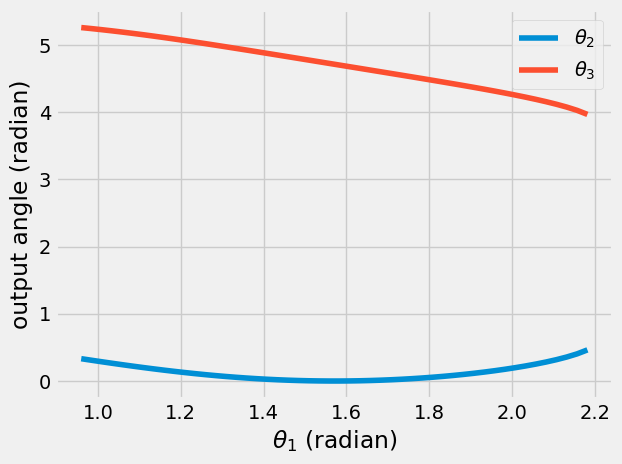

In [415]:
plt.plot(a1, a2, label = r'$\theta_2$')
plt.plot(a1, a3, label = r'$\theta_3$')
plt.xlabel(r'$\theta_1$ (radian)')
plt.ylabel('output angle (radian)')
plt.legend()

## Motion of the links

Now I have the position of the links, but I want to see what it looks like and what paths the components trace. Here, I use the vector definitions to define the positions of the links and connections

- $r_A = l_1 \cos\theta_1\hat{i} + l_1 \sin\theta_1\hat{j}$
- $r_B = r_A + r_{B/A} = r_A + l_2\cos\theta_2\hat{i} + l_2 \sin\theta_2\hat{j}$
- $r_C = r_B + r_{C/B} = r_B - l_3\cos\theta_3\hat{i} - l_3 \sin\theta_3\hat{j}$
- $r_P = r_A + r_{P/A} = r_A + \frac{l_2}{2}\cos\theta_2\hat{i} + \frac{l_2}{2} \sin\theta_2\hat{j}$

In [416]:
rA = l1*np.vstack([np.cos(a1), np.sin(a1)])
rB = rA + l2*np.vstack([np.cos(a2), np.sin(a2)])
rC = np.vstack([dx*np.ones_like(a1), dy*np.ones_like(a1)])

t = 0.50 # modified this parameter to be able to change where the measured point it for better linear approximation
# 0.5 corresponds to the center point like before
rP = rA + t*(rB - rA)

### Plot one orientation and the paths

The paths of the links are now in the variables `rA`, `rB`, `rC`, and `rP`. I will plot the paths of these 4 points and the shape at a point in time. 

In [417]:
links_x_locations = np.vstack([np.zeros(len(a1)), 
                              rA[0, :],
                              rB[0, :],
                              rC[0, :]])

(np.float64(-0.6782019830604384),
 np.float64(1.6235600445461913),
 np.float64(-0.1),
 np.float64(2.1))

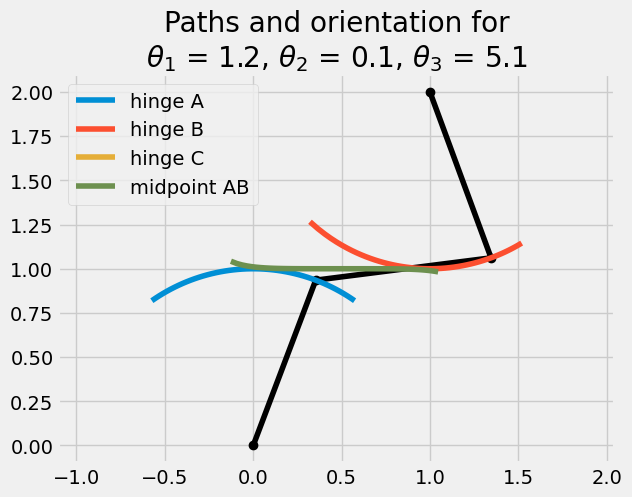

In [418]:
links_y_locations = np.vstack([np.zeros(len(a1)), 
                              rA[1, :],
                              rB[1, :],
                              rC[1, :]])
i = 10
plt.plot(links_x_locations[:, i], 
        links_y_locations[:, i], 'k-o')
plt.plot(rA[0,:], rA[1,:], label = 'hinge A')
plt.plot(rB[0,:], rB[1,:], label = 'hinge B')
plt.plot(rC[0,:], rC[1,:], label = 'hinge C')

plt.plot(rP[0,:], rP[1,:], label = 'midpoint AB')
plt.legend()
plt.title('Paths and orientation for\n'
          r'$\theta_1$ = {:.1f}, $\theta_2$ = {:.1f}, $\theta_3$ = {:.1f}'.format(a1[i], a2[i], a3[i]))
plt.axis('equal')

## Determining the speed of the components

Now, I use the constraint equations from above to determine the speed of the link motion. 

$\frac{d\bar{f}(\bar{x})}{dt}= \left[\begin{array}{c}
f_1(\theta_2,~\theta_3) \\ 
f_2(\theta_2,~\theta_3)\end{array}\right]=\left[\begin{array}{c}
l_1\dot{\theta_1}\cos\theta_1+l_2\dot{\theta_2}\cos\theta_2-l_3\dot{\theta_3}\cos\theta_3\\
l_1\dot{\theta_1}\sin\theta_1+l_2\dot{\theta_2}\sin\theta_2-l_3\dot{\theta_3}\sin\theta_3
\end{array}\right]$

1. define the 2-equation function
2. initialize the solutions for the arrays: `da1`, `da2`, `da3`
3. solve the equations at each step in time in a `for-loop`

In [419]:
drive_rate = 10 #rad/s
dFbar = lambda a1, a2, a3, dx: np.array([l1*drive_rate*np.sin(a1)+\
                                         l2*dx[0]*np.sin(a2)-\
                                         l3*dx[1]*np.sin(a3),\
                                         l1*drive_rate*np.cos(a1)+\
                                         l2*dx[0]*np.cos(a2)-\
                                         l3*dx[1]*np.cos(a3)])



In [420]:
da1 = np.ones(len(a1))*10
da2 = np.zeros(len(a1))
da3 = np.zeros(len(a1))
xsol = np.array([0, 0])


for i in range(len(a1)):
    xsol = fsolve(lambda dx: dFbar(a1[i], a2[i], a3[i], dx), xsol)
    da2[i] = xsol[0]
    da3[i] = xsol[1]

Text(0, 0.5, 'output angular speed (radian/s)')

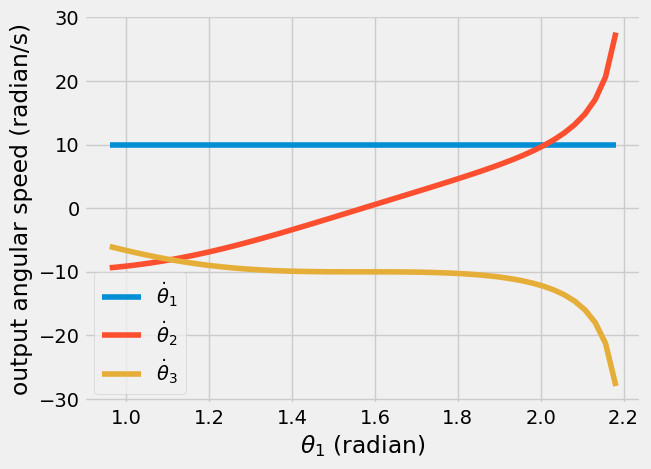

In [421]:
plt.plot(a1, da1, label = r'$\dot{\theta}_1$')
plt.plot(a1, da2, label = r'$\dot{\theta}_2$')
plt.plot(a1, da3, label = r'$\dot{\theta}_3$')
plt.legend()
plt.xlabel(r'$\theta_1$ (radian)')
plt.ylabel('output angular speed (radian/s)')

## Wrapping up

You should edit this notebook to create your own four-bar linkage analysis. 

- Choose a geometry
- plot the motion and paths 
- plot the speeds of the links
- add your own __wrapping up__ section to add any details or further analysis
- what did you learn?


I wrote somewhat about my procedure in the sections above, but continuing, I found it was a lot harder to figure out how to achieve this motion. Linkages, as DEs are exceedingly hard to solve analytically, but after some modifying and working with the terms I ended up with this good result. The website mevirtuoso.com/four-bar-linkage-simulator/ also helped a lot. You can see below the image I made in that program which I based my linkage in the code on.

I learned a lot about Watt linkages, linkages which when tracing out the coupler link, have symmetrical curved shapes. These motions are very repetitve and make nice looking images. If I did choose to extend my attempt at a straight line out to more angles, you would see an intersting double loop (kind of like a knot). I think it's a pretty cool shape.

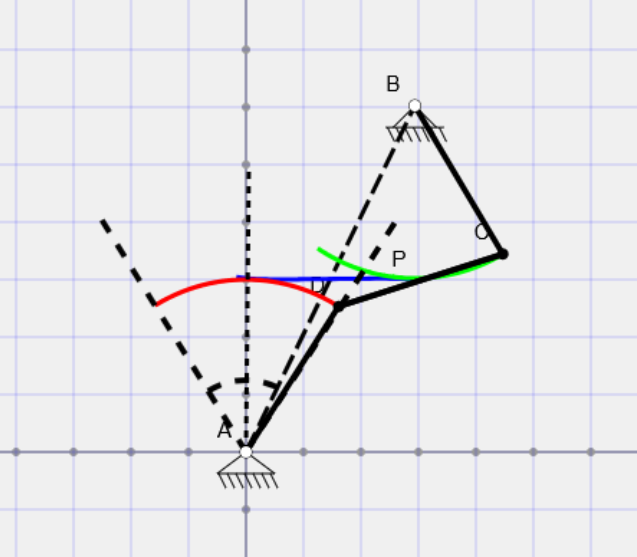

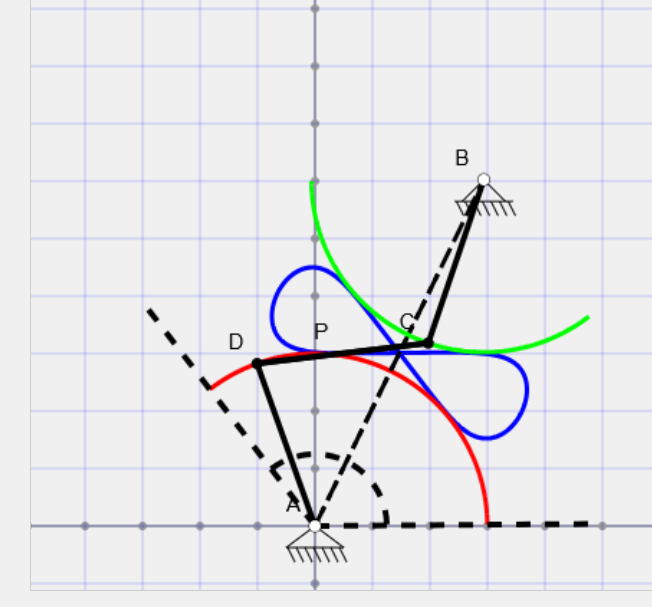